In [2]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit
import scipy.optimize as so
from scipy.signal import unit_impulse
from matplotlib import cm
import numpy.random as npr

In [55]:
def inititalize_arrays(trials, T):
    v = np.zeros((trials+1,T))
    delta_v = np.zeros((trials+1,T))
    delta = np.zeros((trials+1,T))
    w = np.zeros((trials+1,T))
    return v, delta_v, delta, w

@jit(nopython=True)
def timestep(t, u, r, v, delta_v, delta, w, lr, nsteps = 1):
    if nsteps == 0:
        return u, r, v, delta_v, delta, w
    # determine where u(t-tau) is nonzero
    tau = t - np.argwhere(u)[:,0]
    tau = tau[tau >= 0]
    v = np.array([np.sum(w[:t+1] * u[:t+1][::-1]) for t in range(len(v))])
    delta_v = np.concatenate((v[1:] - v[:-1], np.zeros(1)))
    delta = r + delta_v
    w[tau] += lr * delta[t] *  u[t - tau]
    t += 1
    return timestep(t, u, r, v, delta_v, delta, w, lr, nsteps=nsteps-1)

def learn(u, r, lr, trials, T):
    v, delta_v, delta, w = inititalize_arrays(trials, T)
    for trial in range(trials):
        learning_result = timestep(0, u[trial], r[trial], v[trial], delta_v[trial], delta[trial], w[trial], lr, nsteps=T)
        _, _, v[trial+1], delta_v[trial+1], delta[trial+1], w[trial+1] = learning_result
    return u, r, v, delta_v, delta, w

def fit_func(t, h, a, t0, s):
    peak = h * unit_impulse(t.shape, 99)
    gaussian = a * np.exp( -(t - t0)**2 / (2 * s**2))
    return peak + gaussian

def fit_to_delta(t, delta, trials):
    popt = np.zeros((trials+1, 4))
    for trial in range(trials+1):
        p0 = list(popt[trial-1,:-1] if trial > 0 else [0, 0.15, 200]) + [50]
        if np.abs(p0[1]) < 1e-3:
            p0 = (1, -0.01, 200, 50)
        popt[trial,:], _ = so.curve_fit(fit_func, t, delta[trial,:], p0 = p0, bounds=([0,-1,99,0],[10,1,200,50]))
    return np.array(popt)

def simulate(t_array, timespread, n_trials, T, lr):
    u = np.zeros((n_trials+1,T))
    u[:,100] = 1
    r = np.zeros((n_trials+1,T))
    r += 1 / np.sqrt(2 * np.pi * timespread**2) * np.exp(-(t_array - 200)**2 / (2 * timespread**2))
    u, r, v, delta_v, delta, w = learn(u, r, lr, n_trials, T)
    popt = fit_to_delta(t_array, delta, n_trials)
    return u, r, v, delta_v, delta, w, popt

def simulate_with_extinction(t_array, timespread, n_trials, T, lr):
    u = np.zeros((n_trials+1,T))
    u[:,100] = 1
    r = np.zeros((n_trials+1,T))
    r[:n_trials//2] += 1 / np.sqrt(2 * np.pi * timespread**2) * np.exp(-(t_array - 200)**2 / (2 * timespread**2))
    u, r, v, delta_v, delta, w = learn(u, r, lr, n_trials, T)
    popt = fit_to_delta(t_array, delta, n_trials)
    return u, r, v, delta_v, delta, w, popt

def simulate_stochastic_reward(t_array, timespread, p, n_trials, T, lr):
    u = np.zeros((n_trials+1,T))
    u[:,100] = 1
    r = np.zeros((n_trials+1,T))
    mask = npr.uniform(size=n_trials+1) <= p
    r[mask] +=  1 / np.sqrt(2 * np.pi * timespread**2) * np.exp(-(t_array - 200)**2 / (2 * timespread**2))
    u, r, v, delta_v, delta, w = learn(u, r, lr, n_trials, T)
    popt = fit_to_delta(t_array, delta, n_trials)
    return u, r, v, delta_v, delta, w, popt

def simulate_inaccurate_reward_timing(t_array, timespread, sigma_reward_timing, n_trials, T, lr):
    u = np.zeros((n_trials+1,T))
    u[:,100] = 1
    r = np.zeros((n_trials+1,T))
    t_r = npr.normal(0, sigma_reward_timing, size=n_trials+1)
    t, tr = np.meshgrid(t_array, t_r)
    r +=  1 / np.sqrt(2 * np.pi * timespread**2) * np.exp(-(t - 200 - tr)**2 / (2 * timespread**2))
    u, r, v, delta_v, delta, w = learn(u, r, lr, n_trials, T)
    popt = fit_to_delta(t_array, delta, n_trials)
    return u, r, v, delta_v, delta, w, popt

def simulate_two_rewards(t_array, timespread, n_trials, T, lr):
    u = np.zeros((n_trials+1,T))
    u[:,100] = 1
    r = np.zeros((n_trials+1,T))
    r += 1 / np.sqrt(2 * np.pi * timespread**2) * np.exp(-(t_array - 175)**2 / (2 * timespread**2))
    r += 1 / np.sqrt(2 * np.pi * timespread**2) * np.exp(-(t_array - 225)**2 / (2 * timespread**2))
    u, r, v, delta_v, delta, w = learn(u, r, lr, n_trials, T)
    return u, r, v, delta_v, delta, w

def plot_results(t_array, trials, delta):
    fig = plt.figure(figsize=(12,8))

    time, tria = np.meshgrid(t_array, trials)

    ax = fig.add_subplot(1, 2, 1, projection="3d")

    ax.view_init(elev=10, azim=-70, roll=0)
    surf = ax.plot_surface(time, tria, delta, cmap=cm.Greys)
    ax.set_xlabel("$t$")
    ax.set_ylabel("trial")
    ax.set_zlabel("$\delta$")
    fig.tight_layout()

    time, tria = np.meshgrid(t_array, trials)

    ax = fig.add_subplot(1, 2, 2)
    pos = ax.imshow(delta, cmap=cm.viridis, origin="lower")
    ax.set_xlabel("$t$")
    ax.set_ylabel("trial")
    cb = fig.colorbar(pos)
    cb.set_label("$\delta$")
    fig.tight_layout()
    return fig

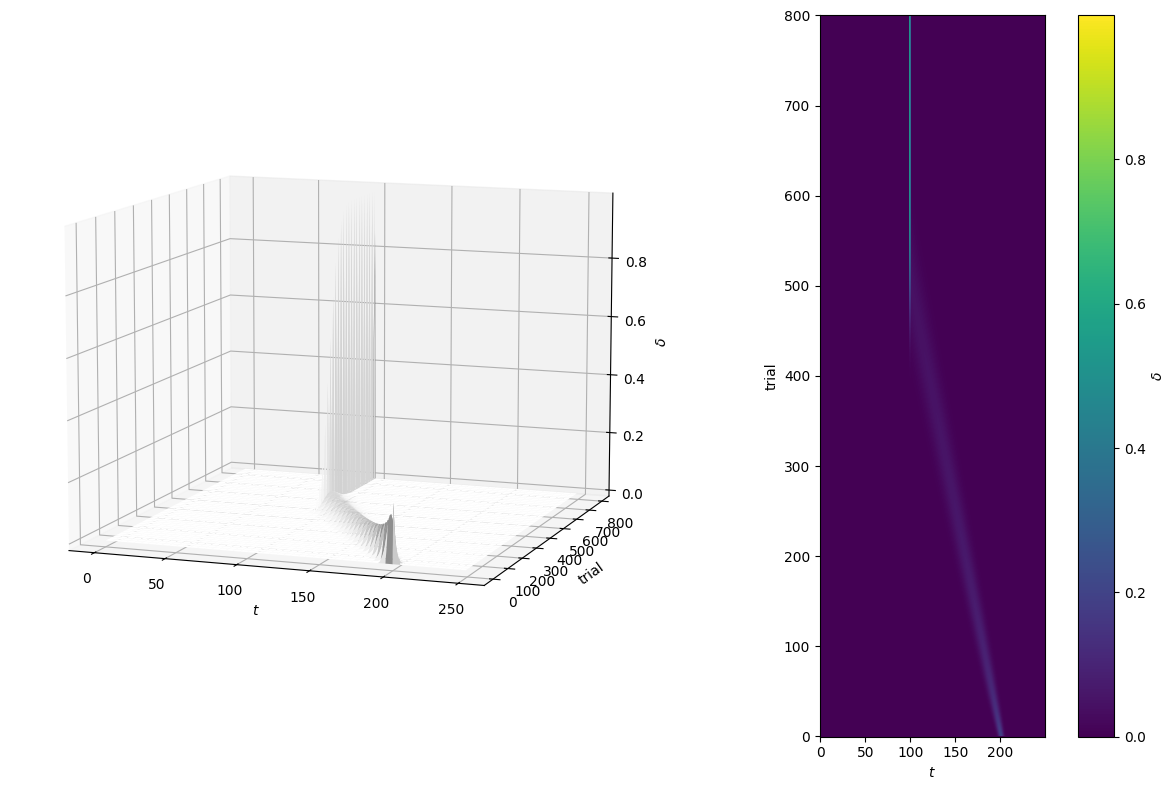

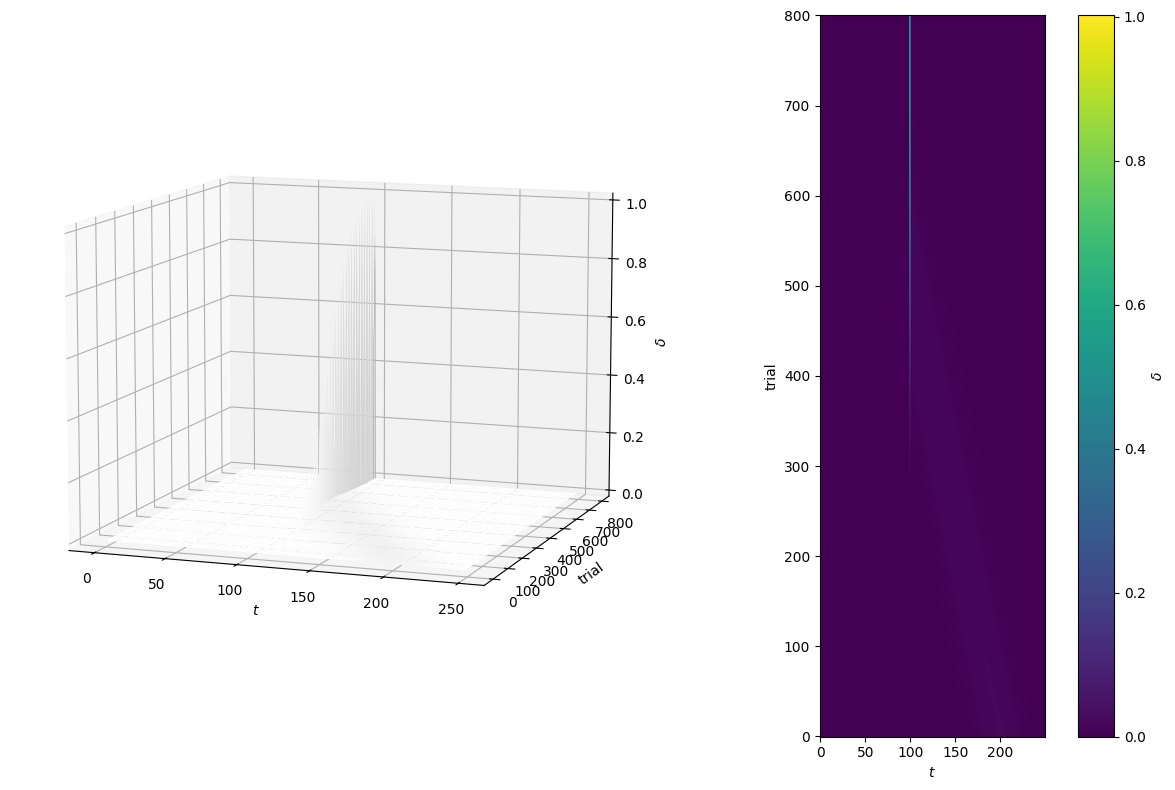

In [37]:
T = 250
n_trials = 800
trials = np.array(range(n_trials+1))
t_array = np.arange(T, dtype=int)
lr = 0.2

u, r, v, delta_v, delta, w, popt = simulate(t_array, 2, n_trials, 250, lr)
fig = plot_results(t_array, trials, delta)
fig.savefig("replication.pdf")

u, r, v, delta_v, delta, w, popt = simulate(t_array, 20, n_trials, 250, lr)
fig = plot_results(t_array, trials, delta)

plt.show()

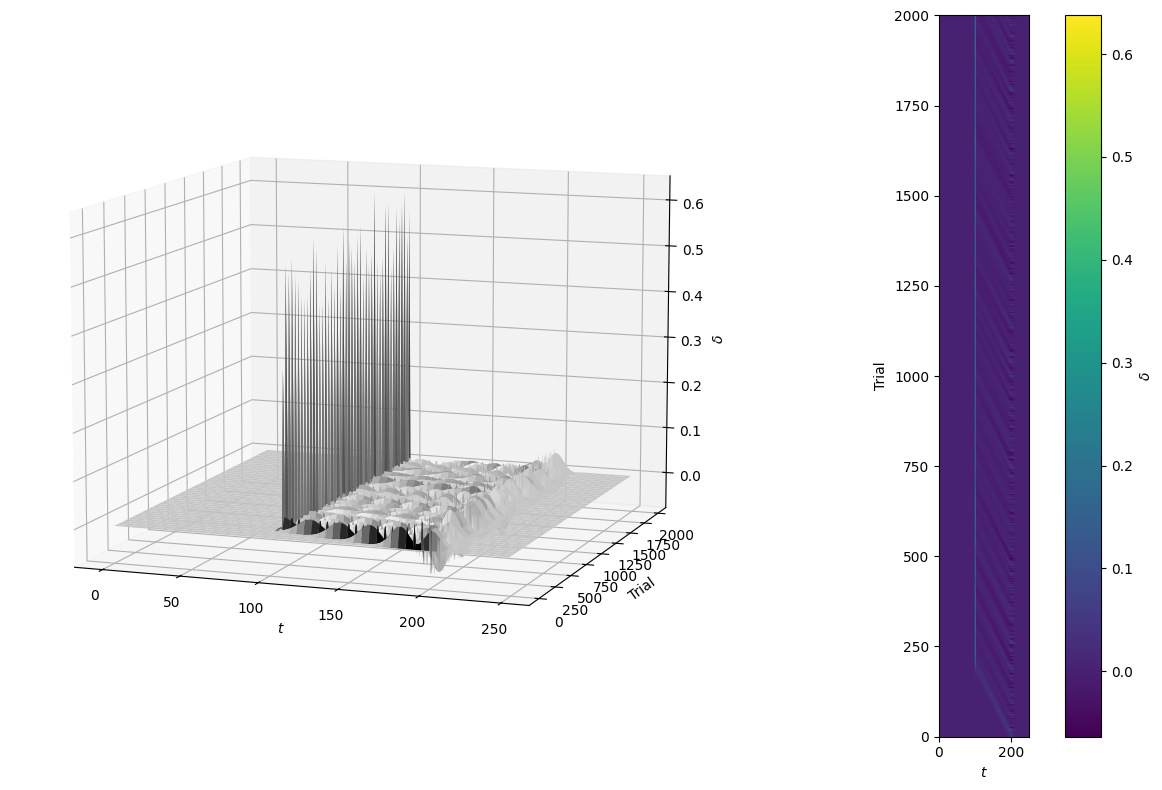

In [4]:
T = 250
n_trials = 2000
trials = np.array(range(n_trials+1))
t_array = np.arange(T, dtype=int)
lr = 0.5
timespread = 5
p = 0.5

u, r, v, delta_v, delta, w, popt = simulate_stochastic_reward(t_array, timespread, p, n_trials, 250, lr)
fig = plot_results(t_array, trials, delta)

# Stochastic rewards

In [44]:
T = 250
n_trials = 2000
trials = np.array(range(n_trials+1))
t_array = np.arange(T, dtype=int)
lr = 0.5
timespread_list = [5] * 4 + [30] * 4
p_list = [1, 0.75, 0.5, 0.25] * 2

cr_list = []

for i, p in enumerate(p_list):
    u, r, v, delta_v, delta, w, popt = simulate_stochastic_reward(t_array, timespread_list[i], p, n_trials, 250, lr)
    cr_list.append(np.cumsum(v, axis=1)[:,-1]/100)


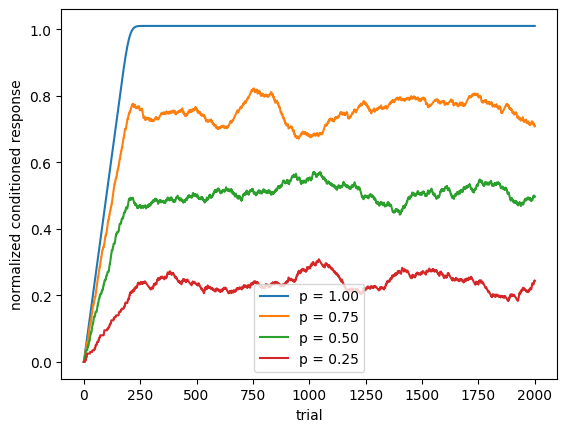

In [48]:
fig, ax = plt.subplots()
for i, cr in enumerate(cr_list[:4]):
    ax.plot(trials, cr, label=f"p = {p_list[i]:.2f}")
ax.set_xlabel("trial")
ax.set_ylabel("normalized conditioned response")
#ax.set_xlim(0,250)
ax.legend(loc=0)
fig.savefig("stochastic_rew.pdf")
plt.show()

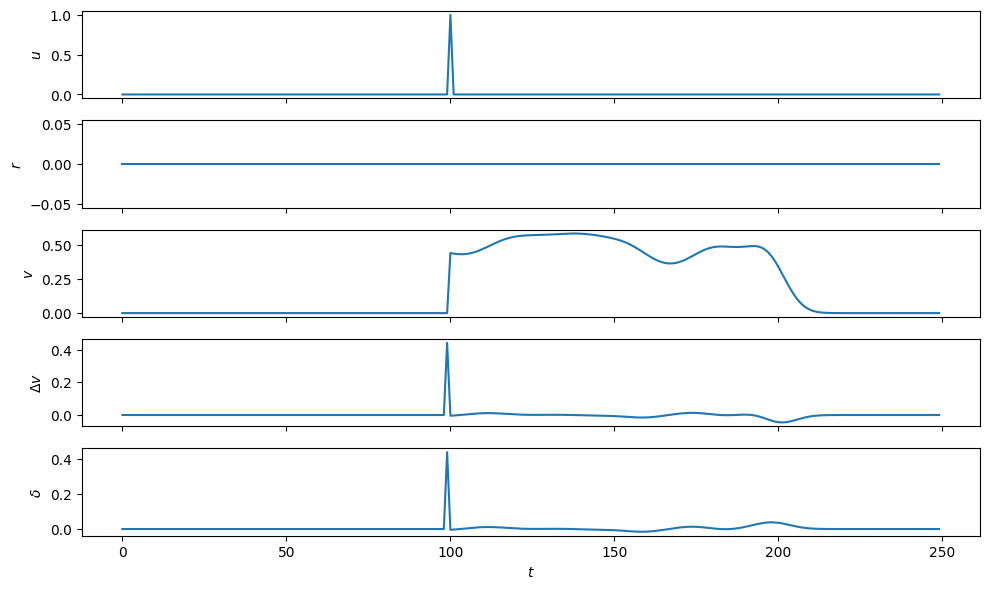

In [70]:
trial = 2000
labels = ["$u$", "$r$", "$v$", "$\Delta v$", "$\delta$"]
fig, axs = plt.subplots(5, 1, figsize=(10, 6), sharex=True)
for i, y in enumerate([u[trial], r[trial], v[trial], delta_v[trial], delta[trial]]):
    axs[i].plot(t_array, y)
    axs[i].set_ylabel(labels[i])
    #axs[i].set_ylim(-0.5,2)
    #if i == 4:
        #axs[i].plot(t_array, fit_func(t_array, *popt[trial,:]))
axs[-1].set_xlabel("$t$")
fig.tight_layout()


# Fit parameters

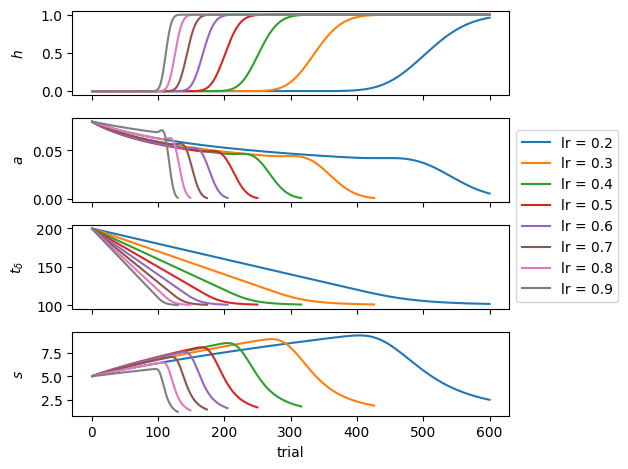

In [40]:
T = 250
n_trials = 600
trials = np.array(range(n_trials+1))
t_array = np.arange(T, dtype=int)

fig, axs = plt.subplots(4, 1, sharex=True)
for lr in np.arange(0.2,1,0.1):
    u, r, v, delta_v, delta, w, popt = simulate(t_array, 5, n_trials, 250, lr)

    labels = ["$h$", "$a$", "$t_\delta$", "$s$"]
    for i in range(4):
        if i == 0:
            axs[i].plot(trials[1:], popt[1:,i], label = f"lr = {lr:.1f}")
        else:
            axs[i].plot(trials[1:][popt[1:,1] > 1e-3], popt[1:,i][popt[1:,1] > 1e-3], label = f"lr = {lr:.1f}")
        axs[i].set_ylabel(labels[i])
    axs[-1].set_xlabel("trial")

fig.tight_layout()
fig.align_labels(axs)
fig.subplots_adjust(right=0.8)
axs[2].legend(loc="lower left", bbox_to_anchor=(1,0))
fig.savefig("lr.pdf")
plt.show()

# Reward function width dependence

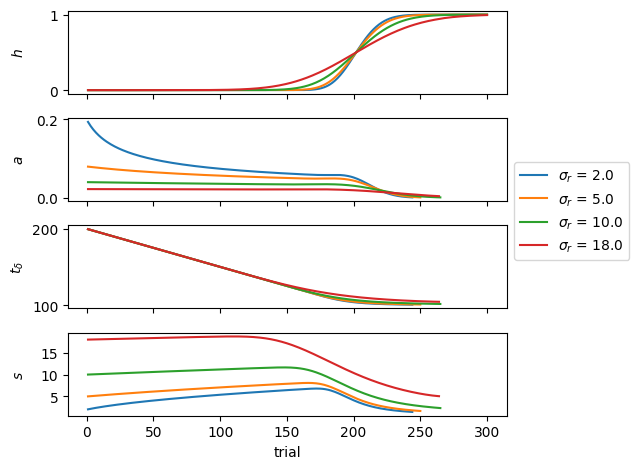

In [52]:
T = 250
n_trials = 300
trials = np.array(range(n_trials+1))
t_array = np.arange(T, dtype=int)

fig, axs = plt.subplots(4, 1, sharex=True)
for timespread in [2, 5, 10, 18]:
    u, r, v, delta_v, delta, w, popt = simulate(t_array, timespread, n_trials, 250, 0.5)

    labels = ["$h$", "$a$", "$t_\delta$", "$s$"]
    for i in range(4):
        if i == 0:
            axs[i].plot(trials[1:], popt[1:,i], label = f"$\sigma_r$ = {timespread:.0f}")
        else:
            axs[i].plot(trials[1:][popt[1:,1] > 1e-3], popt[1:,i][popt[1:,1] > 1e-3], label = f"$\sigma_r$ = {timespread:.1f}")
        axs[i].set_ylabel(labels[i])
    axs[-1].set_xlabel("trial")

fig.tight_layout()
fig.align_labels(axs)
axs[2].legend(loc="lower left", bbox_to_anchor=(1,0.5))
fig.subplots_adjust(right=0.8)
fig.savefig("reward_width_dependence.pdf")
plt.show()

# Extinction

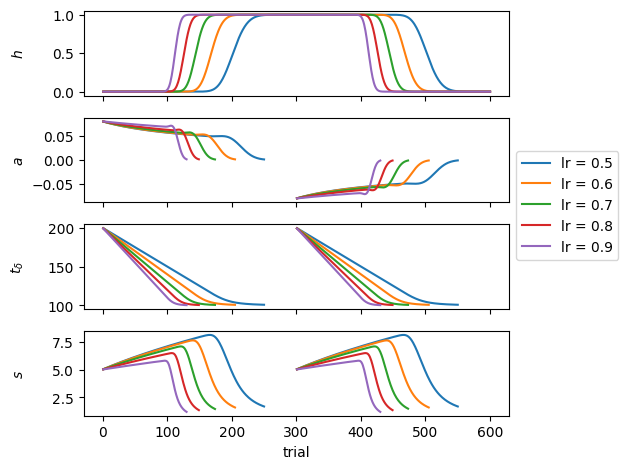

In [51]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

T = 250
n_trials = 600
trials = np.array(range(n_trials+1))
t_array = np.arange(T, dtype=int)
timespread = 5

fig, axs = plt.subplots(4, 1, sharex=True)
for j, lr in enumerate(np.arange(0.5,1,0.1)):
    u, r, v, delta_v, delta, w, popt = simulate_with_extinction(t_array, timespread, n_trials, 250, lr)

    labels = ["$h$", "$a$", "$t_\delta$", "$s$"]
    for i in range(4):
        if i == 0:
            axs[i].plot(trials[1:], popt[1:,i], label = f"lr = {lr:.1f}", c=colors[j])
        else:
            axs[i].plot(trials[1:n_trials//2][np.abs(popt[1:n_trials//2,1]) > 1e-3], popt[1:n_trials//2,i][np.abs(popt[1:n_trials//2,1]) > 1e-3],
                        c=colors[j],
                        label = f"lr = {lr:.1f}")
            axs[i].plot(trials[n_trials//2:][np.abs(popt[n_trials//2:,1]) > 1e-3], popt[n_trials//2:,i][np.abs(popt[n_trials//2:,1]) > 1e-3], c=colors[j])
        axs[i].set_ylabel(labels[i])
    axs[-1].set_xlabel("trial")

fig.tight_layout()
fig.align_labels(axs)
axs[2].legend(loc="lower left", bbox_to_anchor=(1,0.5))
fig.subplots_adjust(right=0.8)
fig.savefig("extinction.pdf")
plt.show()

# Inaccurate reward timings

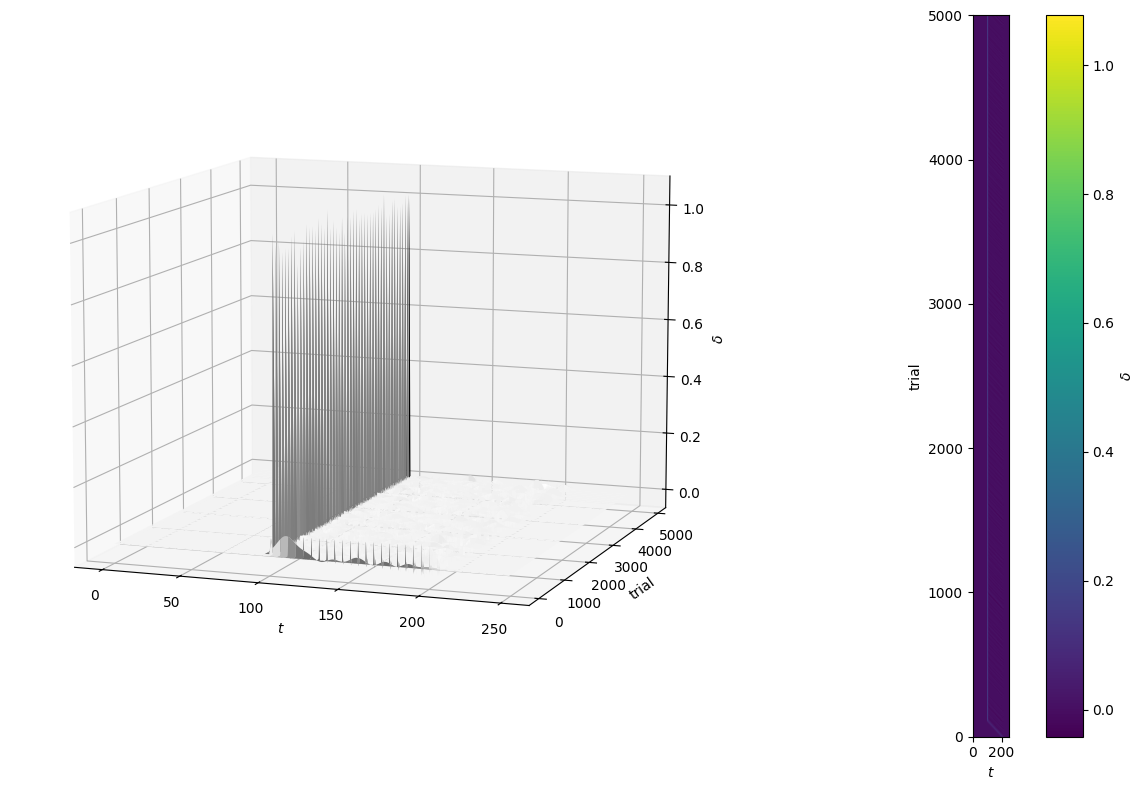

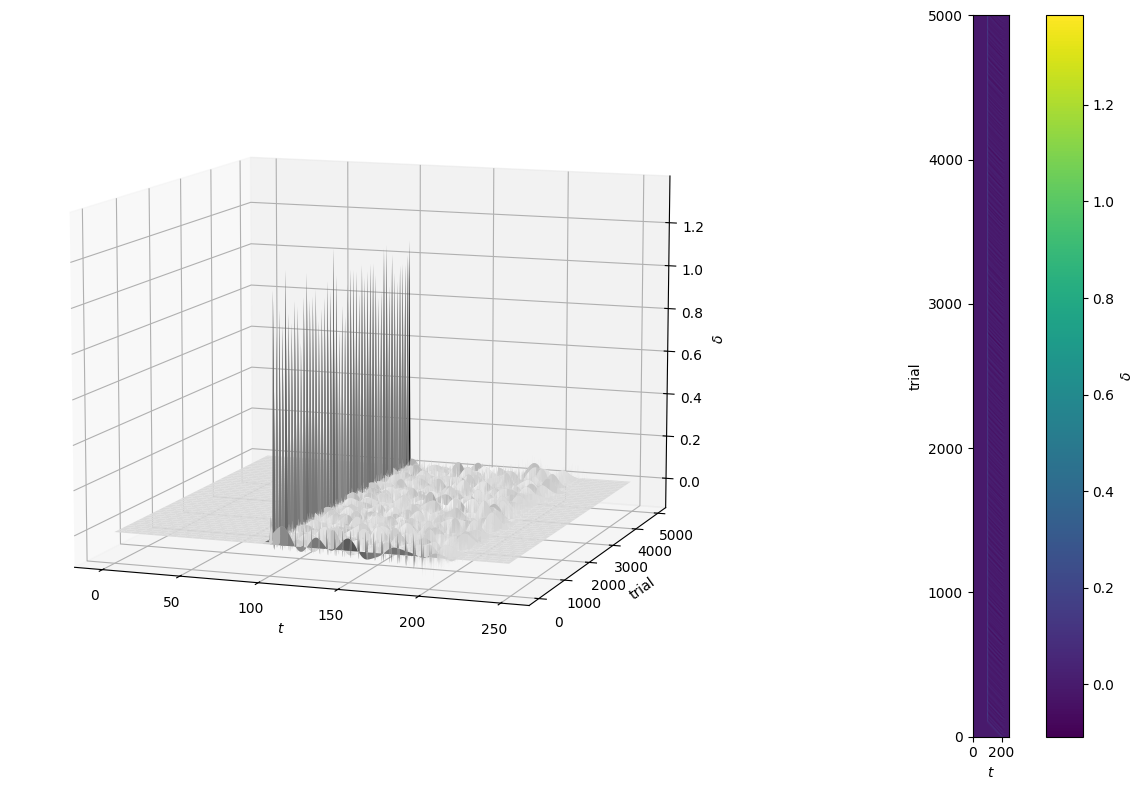

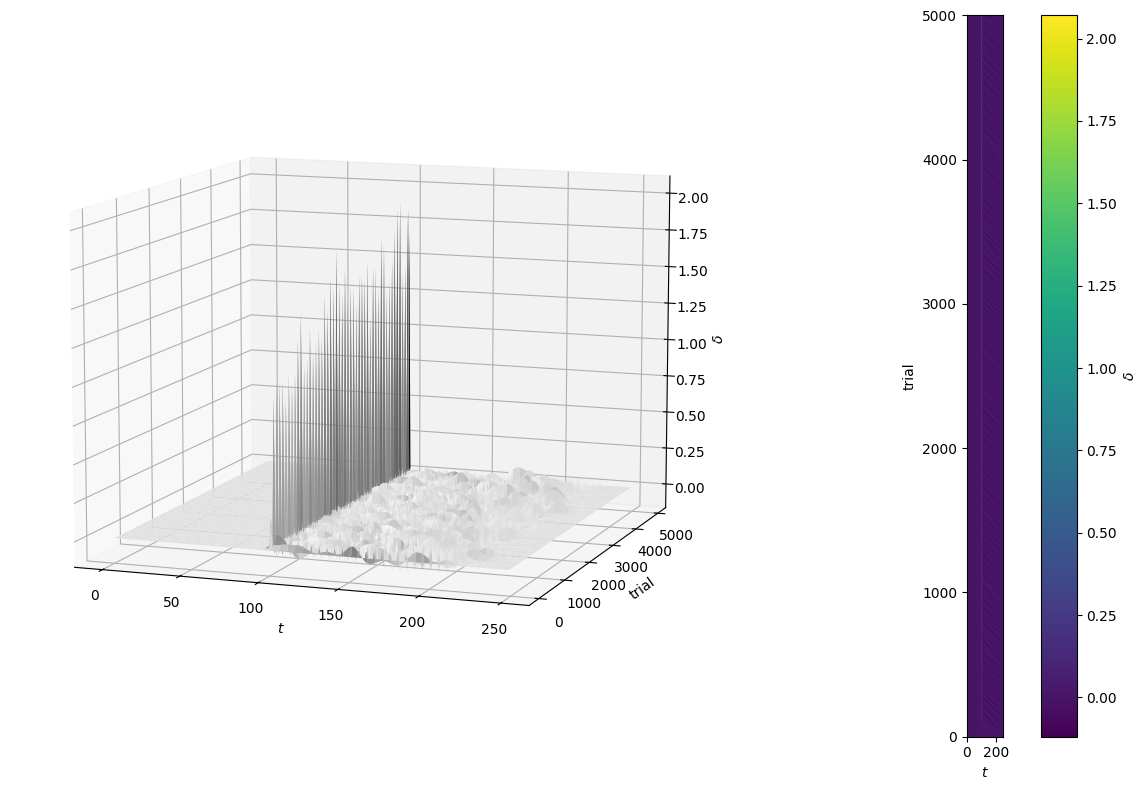

In [69]:
T = 250
n_trials = 5000
trials = np.array(range(n_trials+1))
t_array = np.arange(T, dtype=int)
timespread = 5
sigma_list = [1, 5, 15]
cr_list = []

for sigma in sigma_list:
    u, r, v, delta_v, delta, w, popt = simulate_inaccurate_reward_timing(t_array, timespread, sigma, n_trials, 250, lr)
    plot_results(t_array, trials, delta)
    cr_list.append(np.cumsum(v, axis=1)[:,-1]/100)

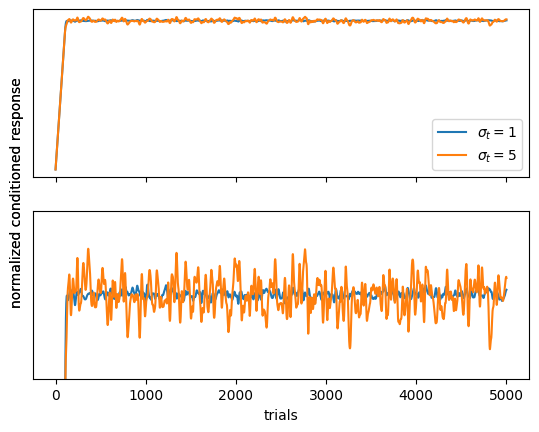

In [82]:
T = 250
n_trials = 5000
trials = np.array(range(n_trials+1))
t_array = np.arange(T, dtype=int)
timespread = 5
sigma_list = [1, 5]

fig, axs = plt.subplots(2,1, sharex=True)
for i in range(len(sigma_list[:])):
    axs[0].plot(trials, cr_list[i], label = f"$\sigma_t = {sigma_list[i]:.0f}$")
    axs[1].plot(trials, cr_list[i])
    axs[0].legend(loc=0)
    axs[1].set_xlabel("trials")
    fig.text(0.1, 0.5, "normalized conditioned response", rotation="vertical", va="center", ha="center")
    axs[1].set_ylim(0.96,1.06)
    axs[0].set_yticks([])
    axs[1].set_yticks([])
fig.savefig("unprecise_timing.pdf")

# Multiple rewards

# Impulse rewards

In [83]:
def inititalize_arrays(trials, T):
    v = np.zeros((trials+1,T))
    delta_v = np.zeros((trials+1,T))
    delta = np.zeros((trials+1,T))
    w = np.zeros((trials+1,T))
    return v, delta_v, delta, w

#@jit(nopython=True)
def timestep(t, u, P_r, v, delta_v, delta, w, lr, nsteps = 1):
    if nsteps == 0:
        return u, P_r, v, delta_v, delta, w
    # determine where u(t-tau) is nonzero
    tau = t - np.argwhere(u)[:,0]
    tau = tau[tau >= 0]
    r = np.zeros(len(u))
    r[int(npr.choice(len(u), p=P_r))] = 1
    v = np.array([np.sum(w[:t+1] * u[:t+1][::-1]) for t in range(len(v))])
    delta_v = np.concatenate((v[1:] - v[:-1], np.zeros(1)))
    delta = r + delta_v
    w[tau] += lr * delta[t] *  u[t - tau]
    t += 1
    return timestep(t, u, P_r, v, delta_v, delta, w, lr, nsteps=nsteps-1)

def learn(u, P_r, lr, trials, T):
    v, delta_v, delta, w = inititalize_arrays(trials, T)
    for trial in range(trials):
        learning_result = timestep(0, u[trial], P_r[trial], v[trial], delta_v[trial], delta[trial], w[trial], lr, nsteps=T)
        _, _, v[trial+1], delta_v[trial+1], delta[trial+1], w[trial+1] = learning_result
    return u, P_r, v, delta_v, delta, w

def simulate_impulse_reward(t_array, t_r, sigma_r, n_trials, T, lr):
    u = np.zeros((n_trials+1,T))
    u[:,100] = 1
    P_r = np.zeros((n_trials+1,T))
    P_r += 1 / np.sqrt(2*np.pi*sigma_r**2) * np.exp(-(t_array - t_r)**2 / (2 * sigma_r**2))
    u, P_r, v, delta_v, delta, w = learn(u, P_r, lr, n_trials, T)
    return u, P_r, v, delta_v, delta, w


In [84]:
T = 250
n_trials = 300
trials = np.array(range(n_trials+1))
t_array = np.arange(T, dtype=int)
lr = 0.5

u, P_r, v, delta_v, delta, w = simulate_impulse_reward(t_array, 200, 5, n_trials, 250, lr)

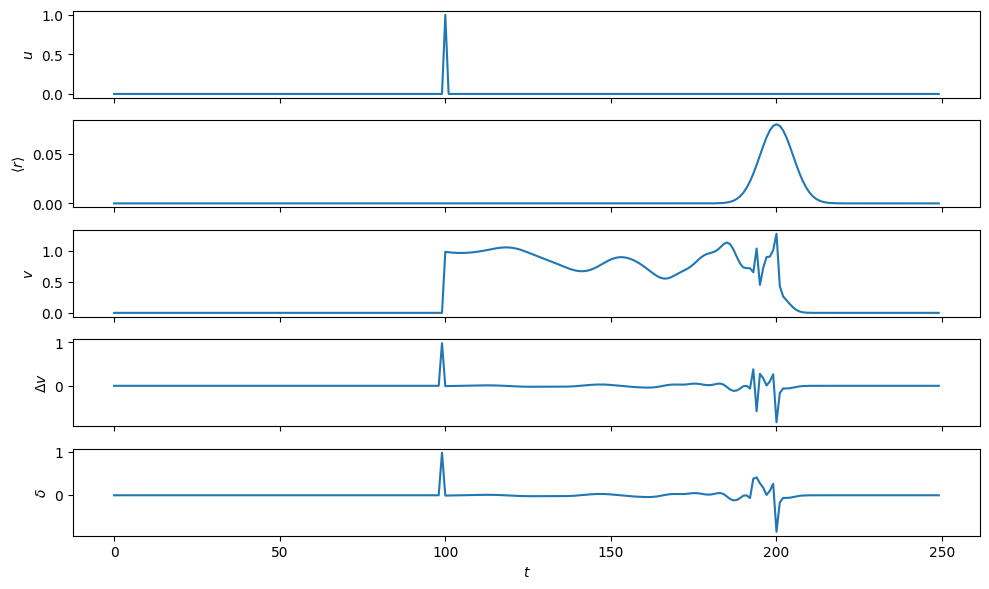

In [85]:
trial = 300
labels = ["$u$", r"$\langle r \rangle$", "$v$", "$\Delta v$", "$\delta$"]
fig, axs = plt.subplots(5, 1, figsize=(10, 6), sharex=True)
for i, y in enumerate([u[trial], P_r[trial], v[trial], delta_v[trial], delta[trial]]):
    axs[i].plot(t_array, y)
    axs[i].set_ylabel(labels[i])
    #axs[i].set_ylim(-0.5,2)
    #if i == 4:
        #axs[i].plot(t_array, fit_func(t_array, *popt[trial,:]))
axs[-1].set_xlabel("$t$")
fig.tight_layout()

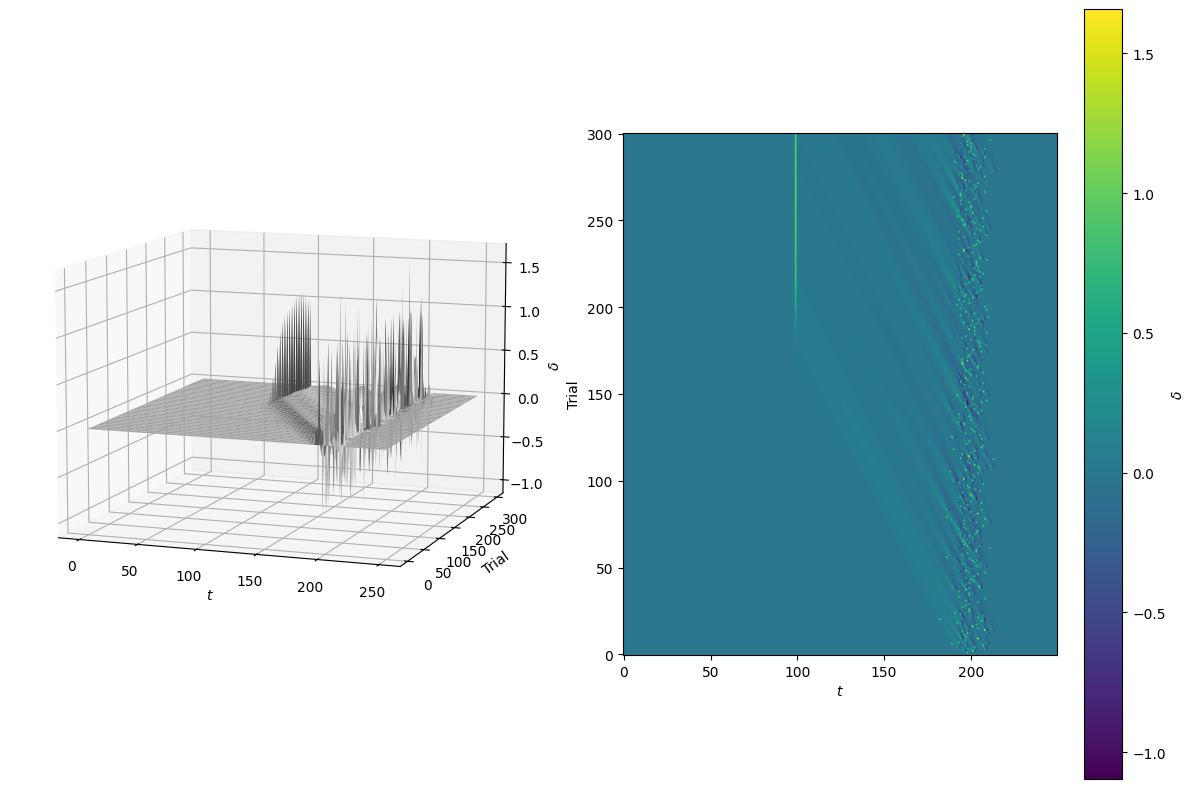

In [86]:
plot_results(t_array, trials, delta)
plt.show()